### Forecasting Wind Turbine Power Output

##### Data Loading & Cleaning

In [35]:
# import datasets
import pandas as pd

turbine_data = pd.read_csv("WindTurbine_Data.csv")
# keeping focused dataset
turbine_data = turbine_data[['Date/Time','Wind Speed (m/s)','LV ActivePower (kW)','Theoretical_Power_Curve (KWh)','Wind Direction (°)']]
turbine_data.head(3)

,Date/Time,Wind Speed (m/s),LV ActivePower (kW),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,5.311336,380.047791,416.328908,259.994904
1,01 01 2018 00:10,5.672167,453.769196,519.917511,268.641113
2,01 01 2018 00:20,5.216037,306.376587,390.900016,272.564789


##### Preprocessing

In [37]:
# Preprocessing
turbine_data.info()
print("Duplicates found from the dataset: ", turbine_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   Wind Speed (m/s)               50530 non-null  float64
 2   LV ActivePower (kW)            50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
Duplicates found from the dataset:  0


In [41]:
# Convert Date/Time to datetime
turbine_data['Date/Time'] = pd.to_datetime(turbine_data['Date/Time'], format="%d %m %Y %H:%M")

# Set Date/Time as index
turbine_data = turbine_data.set_index('Date/Time')

# Check missing values
missing_count = turbine_data.isna().sum()
print("Missing Values per Column:\n", missing_count)

# Apply interpolation only if missing exist
if missing_count.sum() > 0:
    turbine_data = turbine_data.interpolate(method='time')
    print("\nInterpolation applied (time-based).")
else:
    print("\nNo missing values found Skipping interpolation.")


Note: 'Date/Time' was already the index. Ensuring datetime format.
Missing Values per Column:
 Wind Speed (m/s)                 0
LV ActivePower (kW)              0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

No missing values found, Skipping interpolation.


##### Feature Engineering

In [43]:
import numpy as np

#  Wind speed cubic relationship (from aerodynamic power law)
turbine_data['Wind_Speed_Cubed'] = turbine_data['Wind Speed (m/s)'] ** 3

# Convert wind direction to sin and cos (handles circular nature of angles)
turbine_data['Dir_Sin'] = np.sin(np.radians(turbine_data['Wind Direction (°)']))
turbine_data['Dir_Cos'] = np.cos(np.radians(turbine_data['Wind Direction (°)']))

# Rolling average of wind speed (1-hour smoothing, 6 samples per hour)
turbine_data['Rolling_Speed'] = turbine_data['Wind Speed (m/s)'].rolling(window=6, min_periods=1).mean()

# Convert theoretical power curve (KWh to kW for consistency)
turbine_data['Theoretical_kW'] = turbine_data['Theoretical_Power_Curve (KWh)']

# Power deficit (how much power is lost due to air density / yaw / mechanical loss / wake effect)
turbine_data['Power_Deficit'] = turbine_data['Theoretical_kW'] - turbine_data['LV ActivePower (kW)']

# Efficiency (% output compared to theoretical)
turbine_data['Efficiency (%)'] = (turbine_data['LV ActivePower (kW)'] / turbine_data['Theoretical_kW']) * 100

# Display
print(turbine_data.head())

                     Wind Speed (m/s)  LV ActivePower (kW)  \
Date/Time                                                    
2018-01-01 00:00:00          5.311336           380.047791   
2018-01-01 00:10:00          5.672167           453.769196   
2018-01-01 00:20:00          5.216037           306.376587   
2018-01-01 00:30:00          5.659674           419.645904   
2018-01-01 00:40:00          5.577941           380.650696   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  \
Date/Time                                                                
2018-01-01 00:00:00                     416.328908          259.994904   
2018-01-01 00:10:00                     519.917511          268.641113   
2018-01-01 00:20:00                     390.900016          272.564789   
2018-01-01 00:30:00                     516.127569          271.258087   
2018-01-01 00:40:00                     491.702972          265.674286   

                     Wind_Speed_Cubed   Dir_Si

##### EDA

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (12, 6)

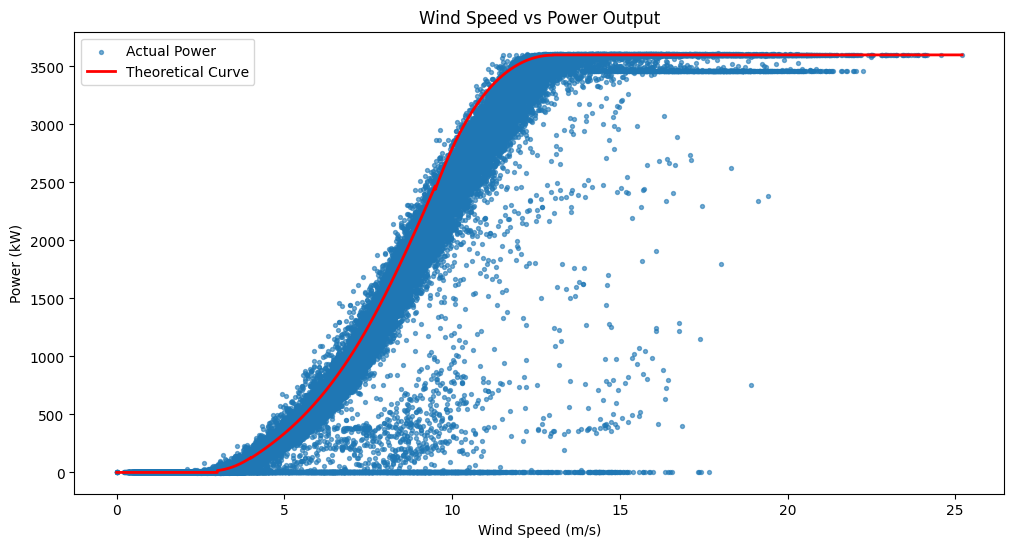

In [46]:
# 1) Scatter: Wind Speed vs Actual + Theoretical Curve
sorted_data = turbine_data.sort_values('Wind Speed (m/s)')

plt.figure()
plt.scatter(turbine_data['Wind Speed (m/s)'],
            turbine_data['LV ActivePower (kW)'],
            s=8, alpha=0.6, label="Actual Power")

plt.plot(sorted_data['Wind Speed (m/s)'],
         sorted_data['Theoretical_kW'], color='red',
         linewidth=2, label="Theoretical Curve")

plt.title("Wind Speed vs Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


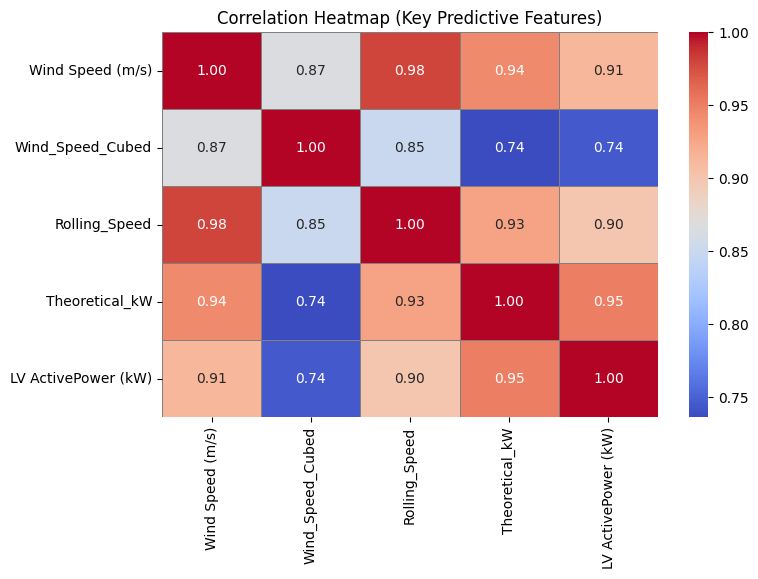

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

features_corr = ['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Rolling_Speed',
                 'Theoretical_kW', 'LV ActivePower (kW)']

corr = turbine_data[features_corr].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=0.5, linecolor='gray')
plt.title("Correlation Heatmap (Key Predictive Features)")
plt.show()


Average Power (kW) by Wind Zone:
Wind_Zone
Low         50.0
Medium    1082.4
High      3114.2
Name: LV ActivePower (kW), dtype: float64


/tmp/ipython-input-3010930337.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_summary = turbine_data.groupby('Wind_Zone')['LV ActivePower (kW)'].mean().round(1)


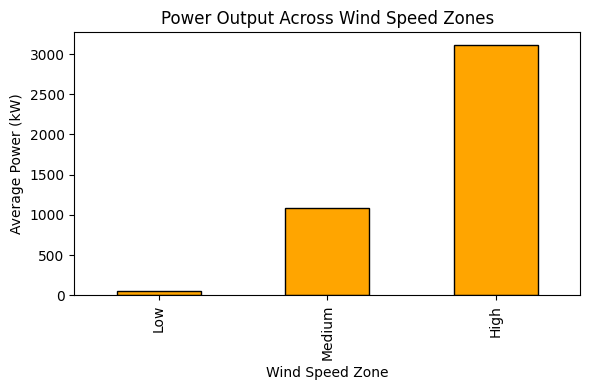

In [56]:
# Wind Speed Zones

bins = [-float('inf'), 5, 10, float('inf')]
labels = ['Low', 'Medium', 'High']

turbine_data['Wind_Zone'] = pd.cut(turbine_data['Wind Speed (m/s)'], bins=bins, labels=labels)

zone_summary = turbine_data.groupby('Wind_Zone')['LV ActivePower (kW)'].mean().round(1)
print("Average Power (kW) by Wind Zone:")
print(zone_summary)

zone_summary.plot(kind='bar', color='orange', edgecolor='black', figsize=(6,4))
plt.ylabel("Average Power (kW)")
plt.xlabel("Wind Speed Zone")
plt.title("Power Output Across Wind Speed Zones")
plt.tight_layout()
plt.show()


#### Week2

##### train-test split

In [ ]:
split_point = int(len(turbine_data) * 0.8)               # We train on first 80% of the year and test on last 20%

train = turbine_data.iloc[:split_point]
test  = turbine_data.iloc[split_point:]

# Features and Target
features = ['Wind Speed (m/s)', 'Wind_Speed_Cubed', 'Dir_Sin', 'Dir_Cos', 'Rolling_Speed']
target = 'LV ActivePower (kW)'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

##### Linear regression

In [57]:
from sklearn.linear_model import LinearRegression

# Linear Regression (Baseline Model)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [58]:
# Predictions
lr_pred = lr_model.predict(X_test)

##### XGBoost Regressor

In [59]:
from xgboost import XGBRegressor

# XGBoost Model (Non-linear performance model)
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [60]:
# Predictions
xgb_pred = xgb_model.predict(X_test)

##### Evaluation.

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)

    print(f"\n{name} Model Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")

evaluate("Linear Regression", y_test, lr_pred)
evaluate("XGBoost", y_test, xgb_pred)


Linear Regression Model Performance:
MAE  : 385.73
RMSE : 527.26
R²   : 0.837

XGBoost Model Performance:
MAE  : 159.06
RMSE : 387.00
R²   : 0.912


##### The better model

In [72]:
# Selecting better model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

best_model = xgb_model if xgb_rmse < lr_rmse else lr_model
print("Selected Best Model:", type(best_model).__name__)

Selected Best Model: XGBRegressor
